<a href="https://colab.research.google.com/github/balajisriraj/Twitter-Summary-mini-Project/blob/main/Twitter_Trend_Finder_In_Progress_V0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Flow:

- Connect to Twittter API using the required creds
- Find the Top trending Hashtags
- Then filter the hashtags which are in English language
- Filter Top 3 Hashtags from that
- For these 3 hashtags, fetch 100 Tweets individually
- Combain all the 100 tweets into one big corpus
- Do basic Data Cleaning & Processing for better Tokenization
- Using Text to Text transformer t5 model Summarize the tweets
- Show Summarized text output for each Hashtag

In [345]:
!pip install googletrans
! pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8afa79e45f2c002676c0fb74b2ea84253bb3db64388730aa8c4f24cb4f8df5d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Import Python Modules

In [353]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from googletrans import Translator
import datetime
import copy
import string
import re
import preprocessor as p
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import os
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY,p.OPT.MENTION)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')

In [354]:
#Past the keys from your local drive


In [355]:
# Consumer key authentication(consumer_key,consumer_secret can be collected from our twitter developer profile)
auth = OAuthHandler(consumer_key, consumer_secret)
# Access key authentication(access_token,access_token_secret can be collected from our twitter developer profile)
auth.set_access_token(access_token, access_token_secret)
# Set up the API with the authentication handler
api = API(auth)

In [356]:
WOE_ID = 2459115 # Where on Earth id can be extracted from https://nations24.com/world-wide
lan_find = Translator() # for finding teh language of the hashtags

In [357]:
def get_location_trends(locations, auth,n_hashtags,lang):
  api = API(auth)
  trends = api.trends_place(locations)
  data = trends[0]
  trends_data = data['trends']
  global tred_data
  tred_data = []
  for info in trends_data:
    tred_data.append([info['name'],info['tweet_volume'],lan_find.detect(info['name']).lang ] )
  tred_data = pd.DataFrame(tred_data, columns = list(['Hashtag',
                                                    'Tweet_Volume', 'Language'])).sort_values(by = ['Tweet_Volume'],ascending = False)
  #select english language trends
  tred_data = tred_data[tred_data.Language == lang]
  #select top 3 trends
  tred_data = tred_data.nlargest(n_hashtags,columns=['Tweet_Volume'])
  return tred_data

In [358]:
df_trending = get_location_trends(WOE_ID,auth,3,'en')
df_trending

,Hashtag,Tweet_Volume,Language
0,Covid,6188244.0,en
45,#BTSWEEK,1185230.0,en
44,#BTSMONTH,641002.0,en


In [398]:
#hashtag_list = list(df_trending['Hashtag'])
hashtag_list = list(['#DMK', '#SPB', '#BJP'])


In [399]:
def extract_tweets_for_htags(no_of_tweets):
  dict_of_df = {} 
  for htag in hashtag_list:
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    tweets = tweepy.Cursor(api.search,q=htag,lang="en",since=today).items(no_of_tweets) #Extracting tweets for the htag
    tweets= [tweet.text for tweet in tweets] # Saving the tweets as list
    
    
    key_name = 'df_htag_'+str(htag)
    dict_of_df[key_name] = copy.deepcopy(tweets)
  return dict_of_df

In [400]:
dict_of_df = extract_tweets_for_htags(50) #Dictionary that has data for all top three hashtags
hashtag_df_list = dict_of_df.keys() #List contains individual the key names for accessing the data inside the dictionary

In [401]:
hashtag_df_list

dict_keys(['df_htag_#DMK', 'df_htag_#SPB', 'df_htag_#BJP'])

In [402]:
def remove_punct(text):
    clean_text = []
    for tweet in text:
      tweet = re.sub(r"http\S+", "", tweet)
      text  = "".join([char for char in tweet if char not in string.punctuation])
      text = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text))
      text = text.replace('RT','').strip()
      clean_text.append(text)
    return clean_text
  

In [403]:
def clean_tweet():
  processed_data_dict = {}
  for htag in hashtag_df_list:
    df = dict_of_df[htag]
    df = remove_punct(df)
    key_name = str(htag)
    processed_data_dict[key_name] = copy.deepcopy(df)
  
  return processed_data_dict 

In [404]:
clean_data = clean_tweet()

In [405]:
clean_data

{'df_htag_#BJP': ['anubhavsinha MumbaiPolice SSRcase is learning for BJP RepublicTV KanganaRanawat',
  'NHIndia MadhyaPradesh Police on Friday evening booked Bharatiya Janata Party BJP and Rashtriya Swayamsevak Sangh RSS workers f',
  'smritiirani Pot calling kettle black Just like BJP interest in SSRcase is for justice and not for political mil',
  'AnuCommon I am sorry RahulGandhi and ManmohanSingh ji for everytime I laughed on the jokes cracked by BJP people on you We failed',
  'Met amp congratulated senior BJP leaders Smt arunadk garu and Sri drlaxmanbjp garu on their appointment as',
  'cprdindia TajinderSTS tarunchughbjp BJP4Punjab BJP4India JPNadda AshwaniSBJP arunsoodbjp SanjayTandonBJP KangMalvinder Dine',
  'ManojbanjaraIYC This is where bjp gets brutally trolled and abused in social mediaYogiAdityanath has deployed a complete police fo',
  'sowmyasarathy 110prsrEconomy back on track with September GST crossing 95K Crores coronavirus economicrecovery BJP',
  'mannankhan8 For

In [406]:
df_clean_data = pd.DataFrame.from_dict(clean_data)

In [407]:
htags = df_clean_data.columns

In [408]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))

<IPython.core.display.Javascript object>

Word Clod for the trending hashtag df_htag_#DMK 



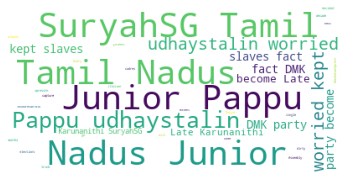

Original text preprocessed: 
 SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, NewIndianXpress xpresstn SKumaresanTNIE Out of power for a decade DMK cadres have no illusion that the 2021 Assembly elections in, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about being kept as slaves In fact DMK party has become Late Karunanithi F, SuryahSG Tamil Nadus Junior Pappu udhaystalin worried about

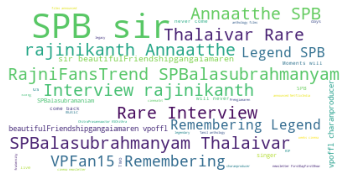

Original text preprocessed: 
 ddtoffl Sad and heartbreaking  RIP legendary singer SPBalasubramaniam SirSPB RIPSPB RIPSPBSir RIPSPBalasubrahmanyan, ddtoffl Sad and heartbreaking  RIP legendary singer SPBalasubramaniam SirSPB RIPSPB RIPSPBSir RIPSPBalasubrahmanyan, RajniFansTrend SPBalasubrahmanyam About Thalaivar Rare Interview rajinikanth Annaatthe SPB, RajniFansTrend SPBalasubrahmanyam About Thalaivar Rare Interview rajinikanth Annaatthe SPB, RamaThatatrayan Satham illatha  AmarkalamLovinglyYoursTeju Song 225amarkalam saran ajithkumar shaliniajith BharadwajRamani, TamilMovies SPB Tribute Director SureshKrissna speaks to baradwajrangan about the tradition of SPB singing th, cinematkt Moments like this will never come back SPB ChitraPrasannaactor KSChithra charanproducer Premgiamaren vpoffl, AnirudhKannan20 While everyone talks about superstar intro song by spb the mother of all intro song is, VincentRK Two days ago we lost our dearest friend to COVID He was also the kindest most humble

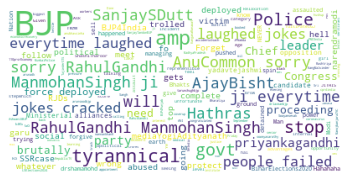

Original text preprocessed: 
 anubhavsinha MumbaiPolice SSRcase is learning for BJP RepublicTV KanganaRanawat, NHIndia MadhyaPradesh Police on Friday evening booked Bharatiya Janata Party BJP and Rashtriya Swayamsevak Sangh RSS workers f, smritiirani Pot calling kettle black Just like BJP interest in SSRcase is for justice and not for political mil, AnuCommon I am sorry RahulGandhi and ManmohanSingh ji for everytime I laughed on the jokes cracked by BJP people on you We failed, Met amp congratulated senior BJP leaders Smt arunadk garu and Sri drlaxmanbjp garu on their appointment as, cprdindia TajinderSTS tarunchughbjp BJP4Punjab BJP4India JPNadda AshwaniSBJP arunsoodbjp SanjayTandonBJP KangMalvinder Dine, ManojbanjaraIYC This is where bjp gets brutally trolled and abused in social mediaYogiAdityanath has deployed a complete police fo, sowmyasarathy 110prsrEconomy back on track with September GST crossing 95K Crores coronavirus economicrecovery BJP, mannankhan8 Forget Congress amp BJP 

In [409]:
for htag in htags:
  temp =  df_clean_data[htag].str.cat(sep=', ') # Select a column insert i here
  #Word Cloud
  print(f'Word Clod for the trending hashtag {htag} \n') 
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40, random_state=42).generate(str(temp))
  fig = plt.figure(1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  preprocess_text = temp.strip().replace("\n","")
  t5_prepared_Text = "summarize: "+preprocess_text
  print ("Original text preprocessed: \n", preprocess_text)
  tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt",  truncation=True)
  # summmarize 
  # summary_ids = model.generate(tokenized_text,max_length=100, num_beams=5,no_repeat_ngram_size=2, 
  #                               num_return_sequences=5, do_sample=True, top_k=50,temperature=0.7,
  #                              early_stopping=True)
  
  summary_ids = model.generate(
    tokenized_text,
    do_sample=True, 
    max_length=75, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
                            )
  
  output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  print(f"\n\nSummarized text for {htag}: \n",output)
  print('*' *100)
  print('\n')
print("Completed")